In [1]:
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np
import random
import math

%matplotlib inline

# Data Loader

In [2]:
import tools._init_paths
import dataset
import torch

from utils.data_manipulation import add_dist_along_vector, add_dict_perpendicular_vector, rotate_point_by_angle

In [3]:
from config import cfg
cfg.merge_from_file('experiments/seaturtle/1_test.yaml')

In [4]:
train_transform = None
valid_transform = None

In [5]:
train_dataset = eval('dataset.'+cfg.DATASET.CLASS)(cfg, True, train_transform)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [6]:
valid_dataset = eval('dataset.'+cfg.DATASET.CLASS)(cfg, False, valid_transform)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=cfg.TRAIN.BS*len(cfg.GPUS),
                                            shuffle=True,
                                            num_workers=cfg.WORKERS,
                                            pin_memory=cfg.PIN_MEMORY
                                        )

In [8]:
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                            batch_size=cfg.TEST.BS*len(cfg.GPUS),
                                            shuffle=False,
                                            num_workers=cfg.WORKERS,
                                            pin_memory=cfg.PIN_MEMORY
                                        )

In [9]:
train_dataset[0][0].shape, train_dataset[0][1:]

((1350, 2400, 3),
 (1525.0,
  929.6875,
  1591.376458322058,
  408.90043623917643,
  871.3541666666667,
  0.12677062717515852))

In [10]:
elem = train_dataset[random.randint(0, len(train_dataset)-1)]

In [11]:
for i, e in enumerate(elem):
    msg = '{} type {} '.format(i, type(e))
    if type(e) == torch.Tensor:
        msg += 'shape {} dtype {}'.format(e.shape, e.dtype)
    elif type(e) == dict:
        msg += '{}'.format(e.keys())
    
    print(msg)

0 type <class 'imageio.core.util.Array'> 
1 type <class 'float'> 
2 type <class 'float'> 
3 type <class 'float'> 
4 type <class 'float'> 
5 type <class 'float'> 
6 type <class 'float'> 


In [12]:
def get_object_aligned_box(xc, yc, xt, yt, w):
    
    corner_1, corner_2 = add_dict_perpendicular_vector([xc, yc], [xt, yt], w)
    dist = np.linalg.norm([xc-xt, yc-yt])
    xt_, yt_ = add_dist_along_vector([xt, yt], [xc, yc], 2*dist)
    corner_3, corner_4 = add_dict_perpendicular_vector([xc, yc], [xt_, yt_], w)
    
    return corner_1, corner_2, corner_3, corner_4

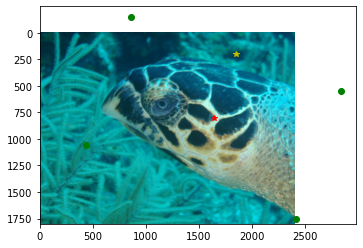

In [13]:
image, xc, yc, xt, yt, w, theta = train_dataset[random.randint(0, len(train_dataset)-1)]
predicted_oa_box = get_object_aligned_box(xc, yc, xt, yt, w)
predicted_oa_box = np.array(predicted_oa_box)

plt.imshow(image)
plt.plot(xc, yc, 'r*')
plt.plot(xt, yt, 'y*')
plt.plot(predicted_oa_box[:,0], predicted_oa_box[:,1], 'go')

In [14]:
def plot_image_coordinates(ax, image, xc, yc, xt, yt, w, theta):
    predicted_oa_box = get_object_aligned_box(xc, yc, xt, yt, w)
    predicted_oa_box = np.array(predicted_oa_box)

    ax.imshow(image)
    ax.plot(xc, yc, 'r*')
    ax.plot(xt, yt, 'y*')
    ax.plot(predicted_oa_box[:,0], predicted_oa_box[:,1], 'go')

## Test augmentation

In [15]:
from dataset.transformers import RandomHorizontalFlip, RandomVerticalFlip, RandomRotate, RandomScale

In [16]:
tf_test = {'Horizontal flip': RandomHorizontalFlip(p=1.), 
           'Vertical flip': RandomVerticalFlip(p=1.),
           'RandomRotations': RandomRotate(degrees=90),
            'RandomScale': RandomScale(scale=(0.8, 1.2))}

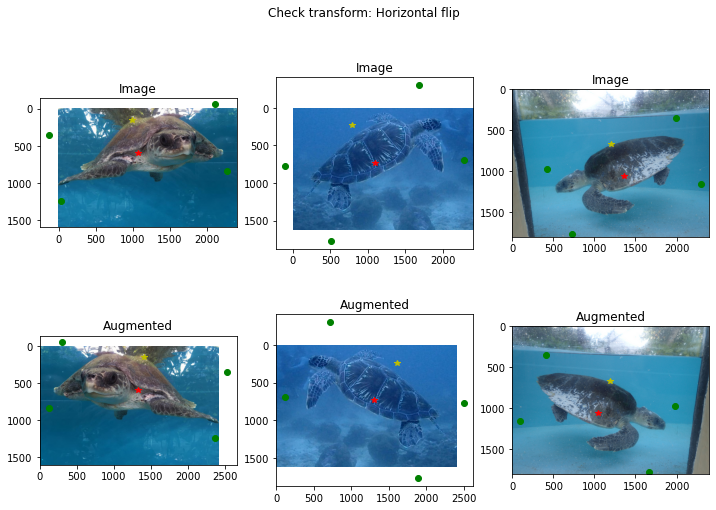

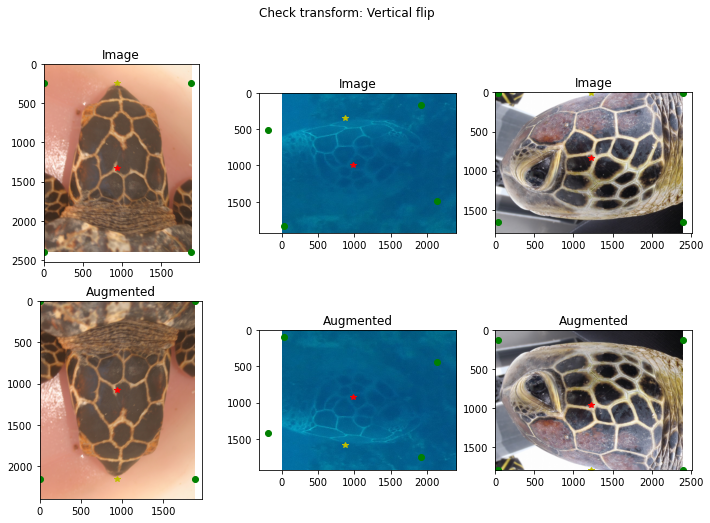

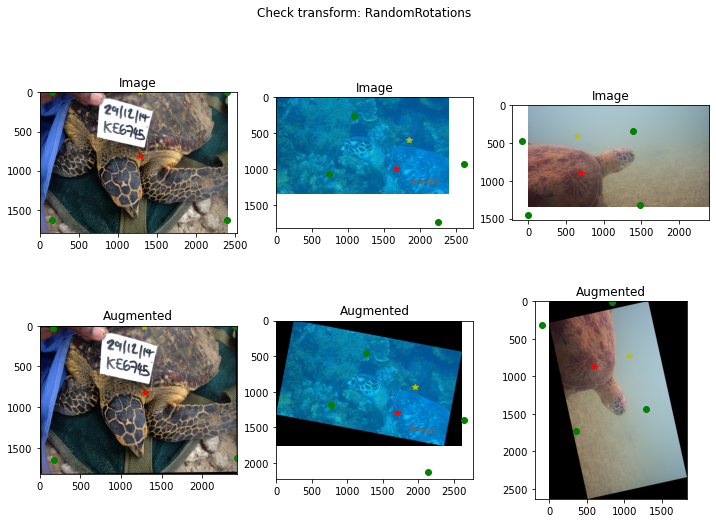

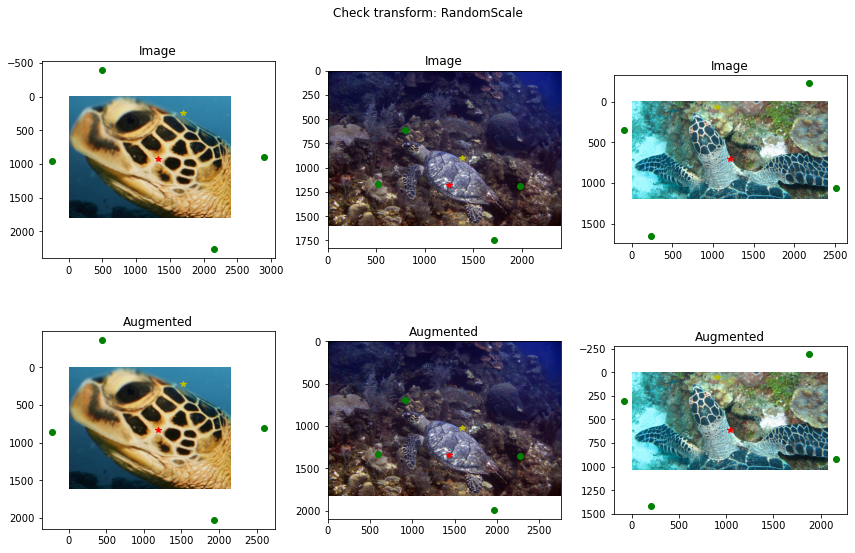

In [17]:
for name, tf in tf_test.items():
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(3*4, 2*4))
    fig.suptitle('Check transform: {}'.format(name))
    for r in range(3):
        image, xc, yc, xt, yt, w, theta = train_dataset[random.randint(0, len(train_dataset)-1)]
        plot_image_coordinates(ax[0, r], image, xc, yc, xt, yt, w, theta)
        ax[0,r].set_title('Image')
        
        #Apply transformation
        image, xc, yc, xt, yt, w, theta = tf((image, xc, yc, xt, yt, w, theta))
        plot_image_coordinates(ax[1, r], image, xc, yc, xt, yt, w, theta)
        ax[1,r].set_title('Augmented')

plt.tight_layout()